In [1]:
#
# Use VGGnet-19 as Convolutional Feature Extractor
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
# @reference https://github.com/anishathalye/neural-style
#

import os, sys
import scipy.io, scipy.misc
import skimage.io
import skimage.transform

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [17]:
def net(data_path, input_image):
    layers = (
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
    )

    data = scipy.io.loadmat(data_path)
    mean = data['normalization'][0][0][0]
    mean_pixel = np.mean(mean, axis=(0, 1))
    weights = data['layers'][0]

    net = {}
    current = input_image
    for i, name in enumerate(layers):
        kind = name[:4]
        if kind == 'conv':
            kernels, bias = weights[i][0][0][0][0]
            # matconvnet: weights are [width, height, in_channels, out_channels]
            # tensorflow: weights are [height, width, in_channels, out_channels]
            kernels = np.transpose(kernels, (1, 0, 2, 3))
            bias = bias.reshape(-1)
            current = _conv_layer(current, kernels, bias)
        elif kind == 'relu':
            current = tf.nn.relu(current)
        elif kind == 'pool':
            current = _pool_layer(current)
        net[name] = current

    assert len(net) == len(layers)
    return net, mean_pixel


def _conv_layer(input, weights, bias):
    conv = tf.nn.conv2d(input, tf.constant(weights), strides=(1, 1, 1, 1),
            padding='SAME')
    return tf.nn.bias_add(conv, bias)


def _pool_layer(input):
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')


def preprocess(image, mean_pixel):
    return image - mean_pixel


def unprocess(image, mean_pixel):
    return image + mean_pixel

print ("VGG net ready")

VGG net ready


In [3]:
# Load npz data
npz_path = "images/MYIMG/my_img_color.npz"

load_data = np.load(npz_path)
print ("Load data : " + str(load_data.files))

train_img = load_data['train_img']
train_label = load_data['train_label']
valid_img = load_data['valid_img']
valid_label = load_data['valid_label']
test_img = load_data['test_img']
test_label = load_data['test_label']

print ("train_img shape : "  + str(train_img.shape))
print ("valid_img shape : "  + str(valid_img.shape))
print ("test_img shape : "  + str(test_img.shape))

Load data : ['valid_img', 'train_img', 'test_img', 'train_label', 'test_label', 'valid_label']
train_img shape : (876, 12288)
valid_img shape : (109, 12288)
test_img shape : (111, 12288)


In [4]:
x_vgg_shape = [-1, 64, 64, 3]

In [5]:
train_img_reshape = np.reshape(train_img, x_vgg_shape)
print ("train_img_reshape's shape : " + str(train_img_reshape.shape))
test_img_reshape = np.reshape(test_img, x_vgg_shape)
print ("test_img_reshape's shape : " + str(test_img_reshape.shape))

train_img_reshape's shape : (876, 64, 64, 3)
test_img_reshape's shape : (111, 64, 64, 3)


(876, 64, 64, 3)


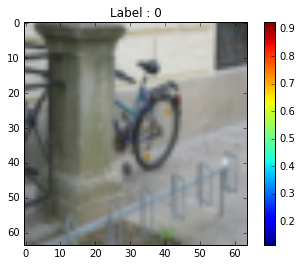

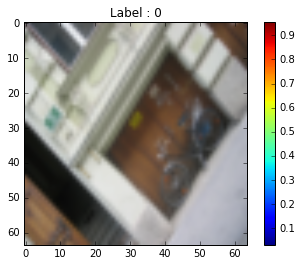

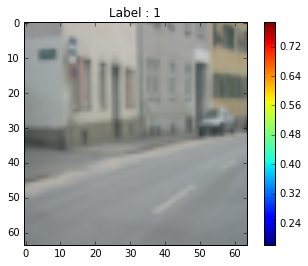

In [9]:
# Plot image
rand_idx = np.arange(train_img.shape[0])
np.random.shuffle(rand_idx)
rand_idx = rand_idx[:3]

print train_img_reshape.shape
for idx in rand_idx:
    label = np.argmax(train_label[idx])
    img = np.reshape(train_img_reshape[idx], (64,64,3))
    plt.imshow(img)
    plt.colorbar()
    plt.title("Label : " + str(label))
    plt.show()

In [6]:
VGG_PATH = "pretrained/imagenet-vgg-verydeep-19.mat"

In [23]:
# Extracting Convolutional feature map
train_features = []
test_features = []

with tf.Graph().as_default(), tf.Session() as sess:
    with tf.device("/gpu:0"):
        img_placeholder = tf.placeholder(tf.float32, shape=(None, 64, 64, 3))
        nets, mean_pixel = net(VGG_PATH, img_placeholder)
        
        for idx in range(train_img_reshape.shape[0]):
            feature = nets['relu5_4'].eval(feed_dict={img_placeholder:train_img_reshape[[idx],:]})
            train_features.append(feature[0])
        train_features = np.array(train_features)
        print ("shape of train vgg conv features : " + str(train_features.shape))
        
        for idx in range(test_img_reshape.shape[0]):
            feature = nets['relu5_4'].eval(feed_dict={img_placeholder:test_img_reshape[[idx],:]})
            test_features.append(feature[0])
        test_features = np.array(test_features)
        print ("shape of test vgg conv features : " + str(test_features.shape))
        
# Change conv feature map to vector
train_vector = np.reshape(train_features, (-1, 4*4*512))
test_vector = np.reshape(test_features, (-1, 4*4*512))
print ("shape of train vgg vector : " + str(train_vector.shape))
print ("shape of test vgg vector : " + str(test_vector.shape))

print("Convolutional feature map extraction done")

shape of train vgg conv features : (876, 4, 4, 512)
shape of test vgg conv features : (111, 4, 4, 512)
shape of train vgg vector : (876, 8192)
shape of test vgg vector : (111, 8192)
Convolutional feature map extraction done


In [34]:
# Options for training
learning_rate = 0.0001
training_epochs = 1000
batch_size = 100
display_step = 100

# Options for Hidden Network Nodes
n_hidden = [1024, 512] # hidden layer's node count
w_dev = 0.1

# Options for dropout
drop_out_ratio = 1.0

In [35]:
# Build Graph of Dropout MLP

# Define placeholder & Variables
x = tf.placeholder("float", [None, train_vector.shape[1]])
y = tf.placeholder("float", [None, train_label.shape[1]])
drop_out_prob = tf.placeholder("float")

def one_layer(_x, _W, _b, _dop):
    return tf.nn.dropout(tf.nn.sigmoid(tf.add(tf.matmul(_x, _W),_b)),_dop)

WS = {}
BS = {}

last_input_layer = x
last_input_layer_size = train_vector.shape[1]
for idx, hl_size in enumerate(n_hidden):
    _W = tf.Variable(tf.random_normal([last_input_layer_size, hl_size], stddev=w_dev))
    _b = tf.Variable(tf.random_normal([hl_size])) 
    last_input_layer = one_layer(last_input_layer, _W, _b, drop_out_prob)
    last_input_layer_size = hl_size
    WS['h_' + str(idx)] = _W
    BS['b_' + str(idx)] = _b

WS['out'] = tf.Variable(tf.random_normal([last_input_layer_size, train_label.shape[1]], stddev=w_dev))
BS['out'] = tf.Variable(tf.random_normal([train_label.shape[1]], stddev=w_dev))


# Define operators

out = tf.add(tf.matmul(last_input_layer, WS['out']),BS['out'])

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

pred = tf.argmax(out, 1)
accr = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(y, 1)),"float"))

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


In [36]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_vector.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_vector.shape[0], size=batch_size)
        batch_xs = train_vector[randidx, :]
        batch_ys = train_label[randidx, :]                
            
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        train_img_acc = sess.run(accr , ({x: batch_xs, y: batch_ys, drop_out_prob : 1.}))
        print ("epoch: %03d/%03d  ,  cost: %.6f  ,  train_img_acc: %.3f" \
               % (epoch, training_epochs, avg_cost, train_img_acc))

test_batch_size = 10
avg_acc = 0.
num_batch_test = int(test_vector.shape[0]/test_batch_size)
for i in range(num_batch_test):
    batch_xs_test = test_vector[i * test_batch_size : (i+1) * test_batch_size ]
    batch_ys_test = test_label[i * test_batch_size : (i+1) * test_batch_size ]            
    avg_acc += sess.run(accr, feed_dict={x : batch_xs_test, y : batch_ys_test, drop_out_prob : 1.})
    
print ("Training complete, Accuracy : %.6f" \
       % (avg_acc / num_batch_test,))

epoch: 000/1000  ,  cost: 1.142288  ,  train_img_acc: 0.400
epoch: 100/1000  ,  cost: 0.010146  ,  train_img_acc: 1.000
epoch: 200/1000  ,  cost: 0.001543  ,  train_img_acc: 1.000
epoch: 300/1000  ,  cost: 0.000536  ,  train_img_acc: 1.000
epoch: 400/1000  ,  cost: 0.000251  ,  train_img_acc: 1.000
epoch: 500/1000  ,  cost: 0.000107  ,  train_img_acc: 1.000
epoch: 600/1000  ,  cost: 0.000055  ,  train_img_acc: 1.000
epoch: 700/1000  ,  cost: 0.000028  ,  train_img_acc: 1.000
epoch: 800/1000  ,  cost: 0.000020  ,  train_img_acc: 1.000
epoch: 900/1000  ,  cost: 0.000011  ,  train_img_acc: 1.000
Training complete, Accuracy : 0.781818
